In [10]:
import os
import numpy as np
import pandas as pd

from datetime import datetime
import warnings

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import time
import pickle

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
# Load the processed data
output_dir = '../processed_data'

# Load all region data from processed .pkl files
region_files = [f for f in os.listdir(output_dir) if f.endswith('.pkl')]

region_data = {}
for file in region_files:
    region_name = file.replace('.pkl', '')
    df = pd.read_pickle(os.path.join(output_dir, file))
    region_data[region_name] = df

In [11]:
# use one region to get started
df = region_data['Zhemgang'].copy()
df.info()

# Drop rows with missing rainfall
df = df.dropna(subset=['Rainfall'])

# Ensure Date is datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

df = df.asfreq('D')  # 'D' = daily (model fit will be slow)
#df = df.asfreq('MS')

# Optional: sort index in case it's not sorted
df = df.sort_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9283 entries, 0 to 9282
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Year      9283 non-null   int64         
 1   Month     9283 non-null   int64         
 2   Day       9283 non-null   int64         
 3   Rainfall  9272 non-null   float64       
 4   Tmax      9282 non-null   float64       
 5   Tmin      9283 non-null   float64       
 6   RH        9190 non-null   float64       
 7   Date      9283 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 580.3 KB


In [12]:
# Set train-test split date
end_train = '2005-12-31'

# Split the data
data_train = df.loc[:end_train]['Rainfall']
data_test = df.loc[end_train:]['Rainfall']

# Print summary of split
print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()} (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()} (n={len(data_test)})"
)

Train dates : 2000-01-01 00:00:00 --- 2005-12-31 00:00:00 (n=2192)
Test dates  : 2005-12-31 00:00:00 --- 2025-05-31 00:00:00 (n=7092)


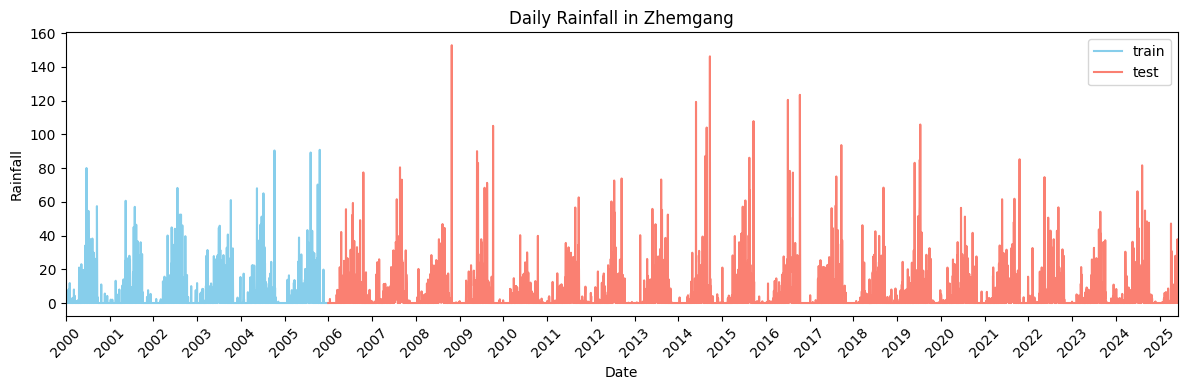

In [13]:
# Plot
fig, ax = plt.subplots(figsize=(12, 4))
data_train.plot(ax=ax, label='train', color='skyblue')
data_test.plot(ax=ax, label='test', color='salmon')

# Format x-axis as dates
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlabel('Date')
ax.set_ylabel('Rainfall')
ax.set_title('Daily Rainfall in Zhemgang')
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# prepare to do SARIMAX modeling using statsmodels
# do some EDA first to know
# stationarity
# autocorrelation analysis
# seasonal decomposition

Test stationarity for original series
--------------------------------------
ADF Statistic: -5.6713, p-value: 0.0000
KPSS Statistic: 0.0950, p-value: 0.1000

Test stationarity for differenced series (order=1)
---------------------------------------------------
ADF Statistic: -15.3578, p-value: 0.0000
KPSS Statistic: 0.0495, p-value: 0.1000

Test stationarity for differenced series (order=2)
---------------------------------------------------
ADF Statistic: -19.5499, p-value: 0.0000
KPSS Statistic: 0.0323, p-value: 0.1000


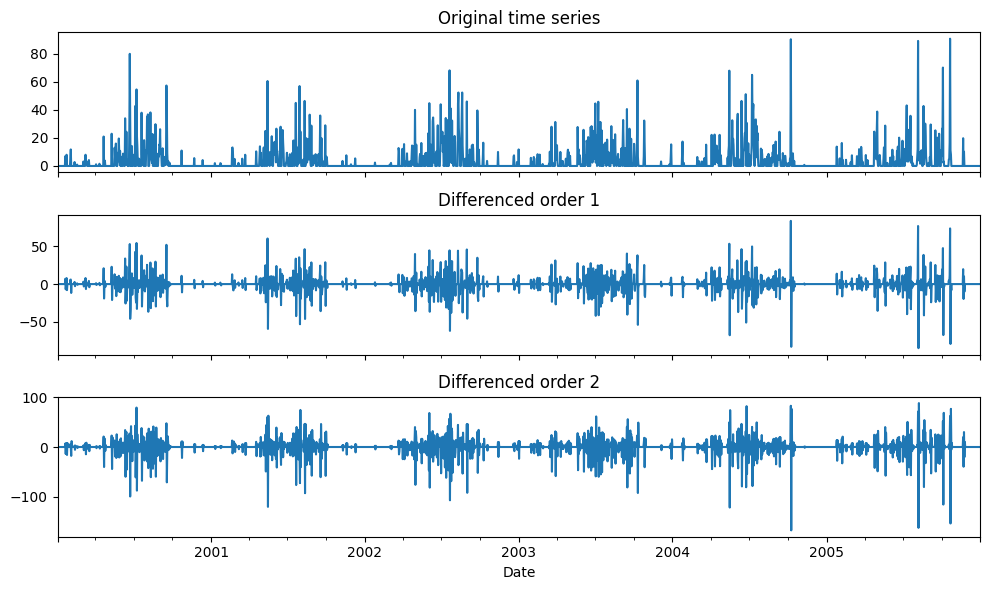

In [14]:
# Use the training data from earlier
data = data_train.copy()

# First and second differencing
data_diff_1 = data.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

# Silence warnings
warnings.filterwarnings("ignore")

# === ADF & KPSS tests ===
print('Test stationarity for original series')
print('--------------------------------------')
adf_result = adfuller(data.dropna())
kpss_result = kpss(data.dropna(), nlags="auto")
print(f'ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}')
print(f'KPSS Statistic: {kpss_result[0]:.4f}, p-value: {kpss_result[1]:.4f}')

print('\nTest stationarity for differenced series (order=1)')
print('---------------------------------------------------')
adf_result = adfuller(data_diff_1)
kpss_result = kpss(data_diff_1, nlags="auto")
print(f'ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}')
print(f'KPSS Statistic: {kpss_result[0]:.4f}, p-value: {kpss_result[1]:.4f}')

print('\nTest stationarity for differenced series (order=2)')
print('---------------------------------------------------')
adf_result = adfuller(data_diff_2)
kpss_result = kpss(data_diff_2, nlags="auto")
print(f'ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}')
print(f'KPSS Statistic: {kpss_result[0]:.4f}, p-value: {kpss_result[1]:.4f}')

# Reset warnings
warnings.filterwarnings("default")

# === Plot the series ===
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), sharex=True)
data.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2')
plt.tight_layout()
plt.show()


### Conclusion of the stationary tests
- Rainfall time series is already stationary based on both tests.
- Differencing is not required for stationarity.
- Decide to set d = 0 in your SARIMAX model.

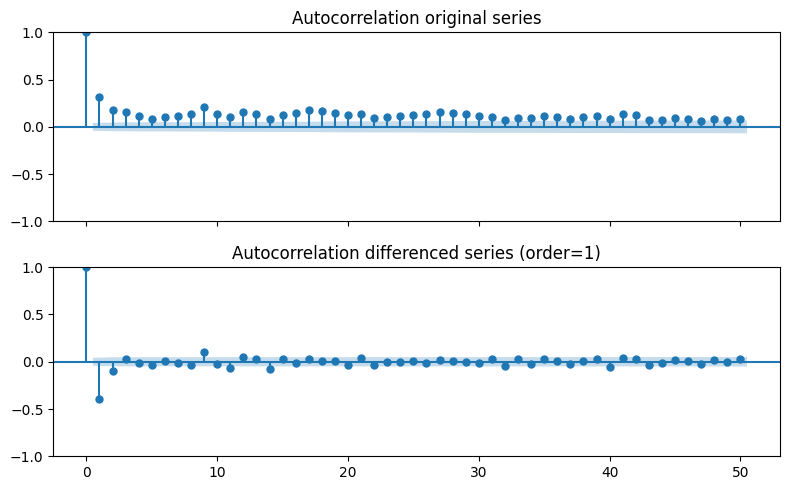

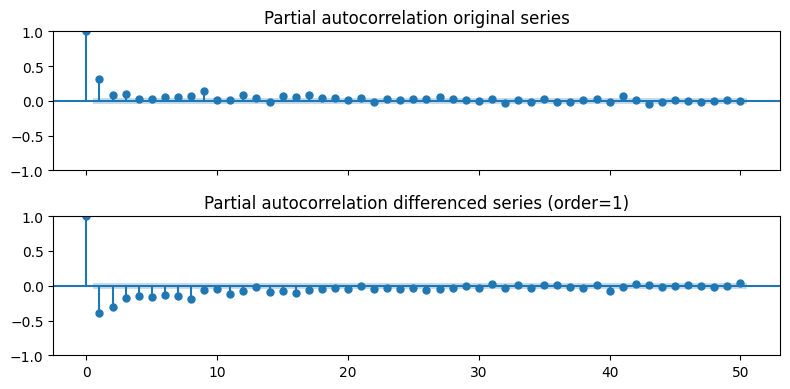

In [15]:
# Original and differenced series
data = data_train.copy()
data_diff_1 = data.diff().dropna()

# === ACF plots ===
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), sharex=True)
plot_acf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differenced series (order=1)')
plt.tight_layout()
plt.show()

# === PACF plots ===
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 4), sharex=True)
plot_pacf(data, ax=axs[0], lags=50, alpha=0.05, method='ywm')  # more stable method
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=50, alpha=0.05, method='ywm')
axs[1].set_title('Partial autocorrelation differenced series (order=1)')
plt.tight_layout()
plt.show()


### Summary of autocorrelation and partial autocorrelation
- moving average
- autocorrelation


### Do seasonal decomposition

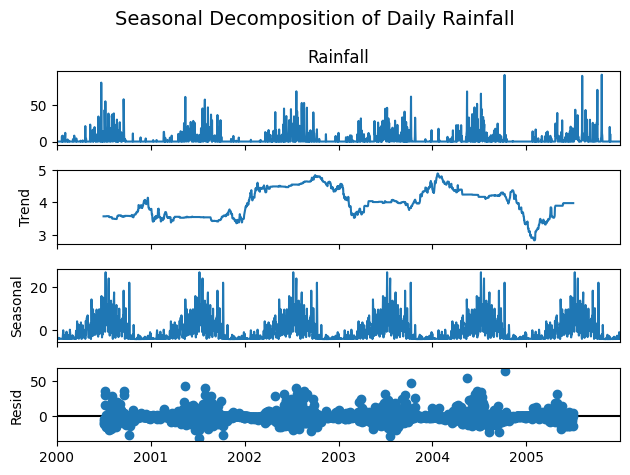

In [8]:

# Make sure index has daily freq
daily_rainfall = data_train.asfreq('D').fillna(0)

# Decompose with yearly seasonality
result = seasonal_decompose(daily_rainfall, model='additive', period=365)
result.plot()

plt.suptitle("Seasonal Decomposition of Daily Rainfall", fontsize=14)
plt.tight_layout()
plt.show()


### Use SARIMAX with daily data + seasonal component
- order = (p, d, q)
- p: autoregressive (AR) term, using lagged value
- d: differencing order to remove trend
- q: moving average (MA) term, using past forecast errors to model current value
- here we use p=1 (use 1 lag of rainfall value), d=0 (already stationary), and 1 lag of the forecast error
- seasonal order: capture repeating patterns

In [7]:
# this block may take a while to run


start = time.time()

# Fit SARIMAX with **yearly seasonality**
model = SARIMAX(data_train,
                order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 365),  # s=365 = annual seasonality on daily data
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=True)

end = time.time()
print(f"Model fitting completed in {(end - start) / 60:.2f} minutes.")

# Save the fitted model
with open('../model/sarimax_model.pkl', 'wb') as f:
    pickle.dump(results, f)
print("Model saved to ../model/sarimax_model.pkl")

print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02950D+00    |proj g|=  9.06223D-02


 This problem is unconstrained.



At iterate    1    f=  3.02618D+00    |proj g|=  3.71159D-02

At iterate    2    f=  3.02567D+00    |proj g|=  2.78194D-02

At iterate    3    f=  3.02386D+00    |proj g|=  4.27415D-02

At iterate    4    f=  3.02188D+00    |proj g|=  5.86304D-02

At iterate    5    f=  3.01753D+00    |proj g|=  8.68038D-02

At iterate    6    f=  3.01344D+00    |proj g|=  5.89587D-02

At iterate    7    f=  3.00988D+00    |proj g|=  6.78896D-02

At iterate    8    f=  3.00821D+00    |proj g|=  5.94721D-02

At iterate    9    f=  3.00751D+00    |proj g|=  6.50007D-02

At iterate   10    f=  3.00669D+00    |proj g|=  6.03098D-02

At iterate   11    f=  3.00513D+00    |proj g|=  7.45926D-02

At iterate   12    f=  3.00447D+00    |proj g|=  1.13137D-01

At iterate   13    f=  3.00399D+00    |proj g|=  2.70846D-02

At iterate   14    f=  3.00385D+00    |proj g|=  2.37567D-02

At iterate   15    f=  3.00352D+00    |proj g|=  2.63804D-02

At iterate   16    f=  3.00311D+00    |proj g|=  1.51416D-02

At iter

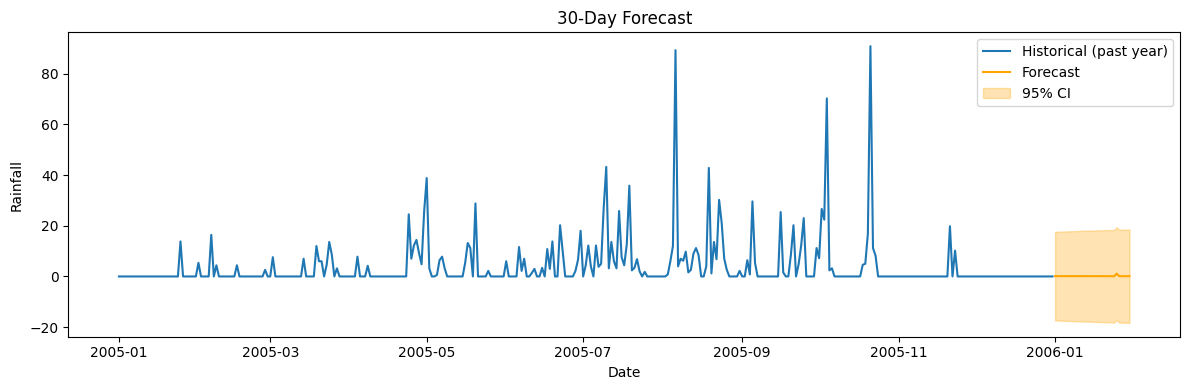

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Set number of days to forecast
n_forecast = 30

# Create forecast
pred = results.get_forecast(steps=n_forecast)

# Get predicted mean and confidence intervals
forecast_mean = pred.predicted_mean
conf_int = pred.conf_int()

# Create a date range for the forecast
last_date = data_train.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast, freq='D')

# Align forecast with index
forecast_mean.index = forecast_index
conf_int.index = forecast_index

# Plot the forecast
plt.figure(figsize=(12, 4))
plt.plot(data_train.index[-365:], data_train[-365:], label='Historical (past year)')
plt.plot(forecast_mean, label='Forecast', color='orange')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3, label='95% CI')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.title('30-Day Forecast')
plt.legend()
plt.tight_layout()
plt.show()
